In [1]:
import json
import sys
from pathlib import Path
import os
import pickle
import pandas as pd
from copy import deepcopy
from tqdm import tqdm
import json
from pathlib import Path
import numpy as np

module_path = str(Path.cwd().parents[0] / "Q1")
if module_path not in sys.path:
    sys.path.append(module_path)
import utils

import pandas as pd
import numpy as np

module_path2 = str(Path.cwd().parents[0] / "Q4/PyDREAM/pydream")
if module_path2 not in sys.path:
    sys.path.append(module_path2)
    
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_import_factory
from pm4py.objects.petri.exporter.exporter import pnml as pnml_exporter
from pm4py.objects.petri.importer.importer import pnml as pnml_importer
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
# from pm4py.objects.log.importer.csv import importer as csv_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.util import get_log_representation

from LogWrapper import LogWrapper
from EnhancedPN import EnhancedPN
from predictive.nap.NAP import NAP
from predictive.nap.NAPr import NAPr
from util.TimedStateSamples import loadTimedStateSamples

# Imports for ML
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from pm4py.visualization.petrinet import visualizer as pn_vis_factory
from graphviz import *

# Import utils.py from Q1 folder
module_path = str(Path.cwd().parents[0] / "Q1")
if module_path not in sys.path:
    sys.path.append(module_path)
import utils

from pm4py.visualization.petrinet import visualizer
from pm4py.algo.enhancement.decision import algorithm as decision_mining
from pm4py.objects.log.importer.xes import importer as xes_importer

# inductive miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# Heuristics miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

from pm4py.util import constants

# len(log.loc[log['Undesired Outcome 1'] == True])
pd.set_option('display.max_columns', None)

/home/rowan/school/process-mining-assignment-2/../pydream
/home/rowan/school/process-mining-assignment-2/pydream


/home/rowan/.local/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


/home/rowan/school/process-mining-assignment-2/pydream


In [2]:
log = xes_importer.apply('Payment application.xes')

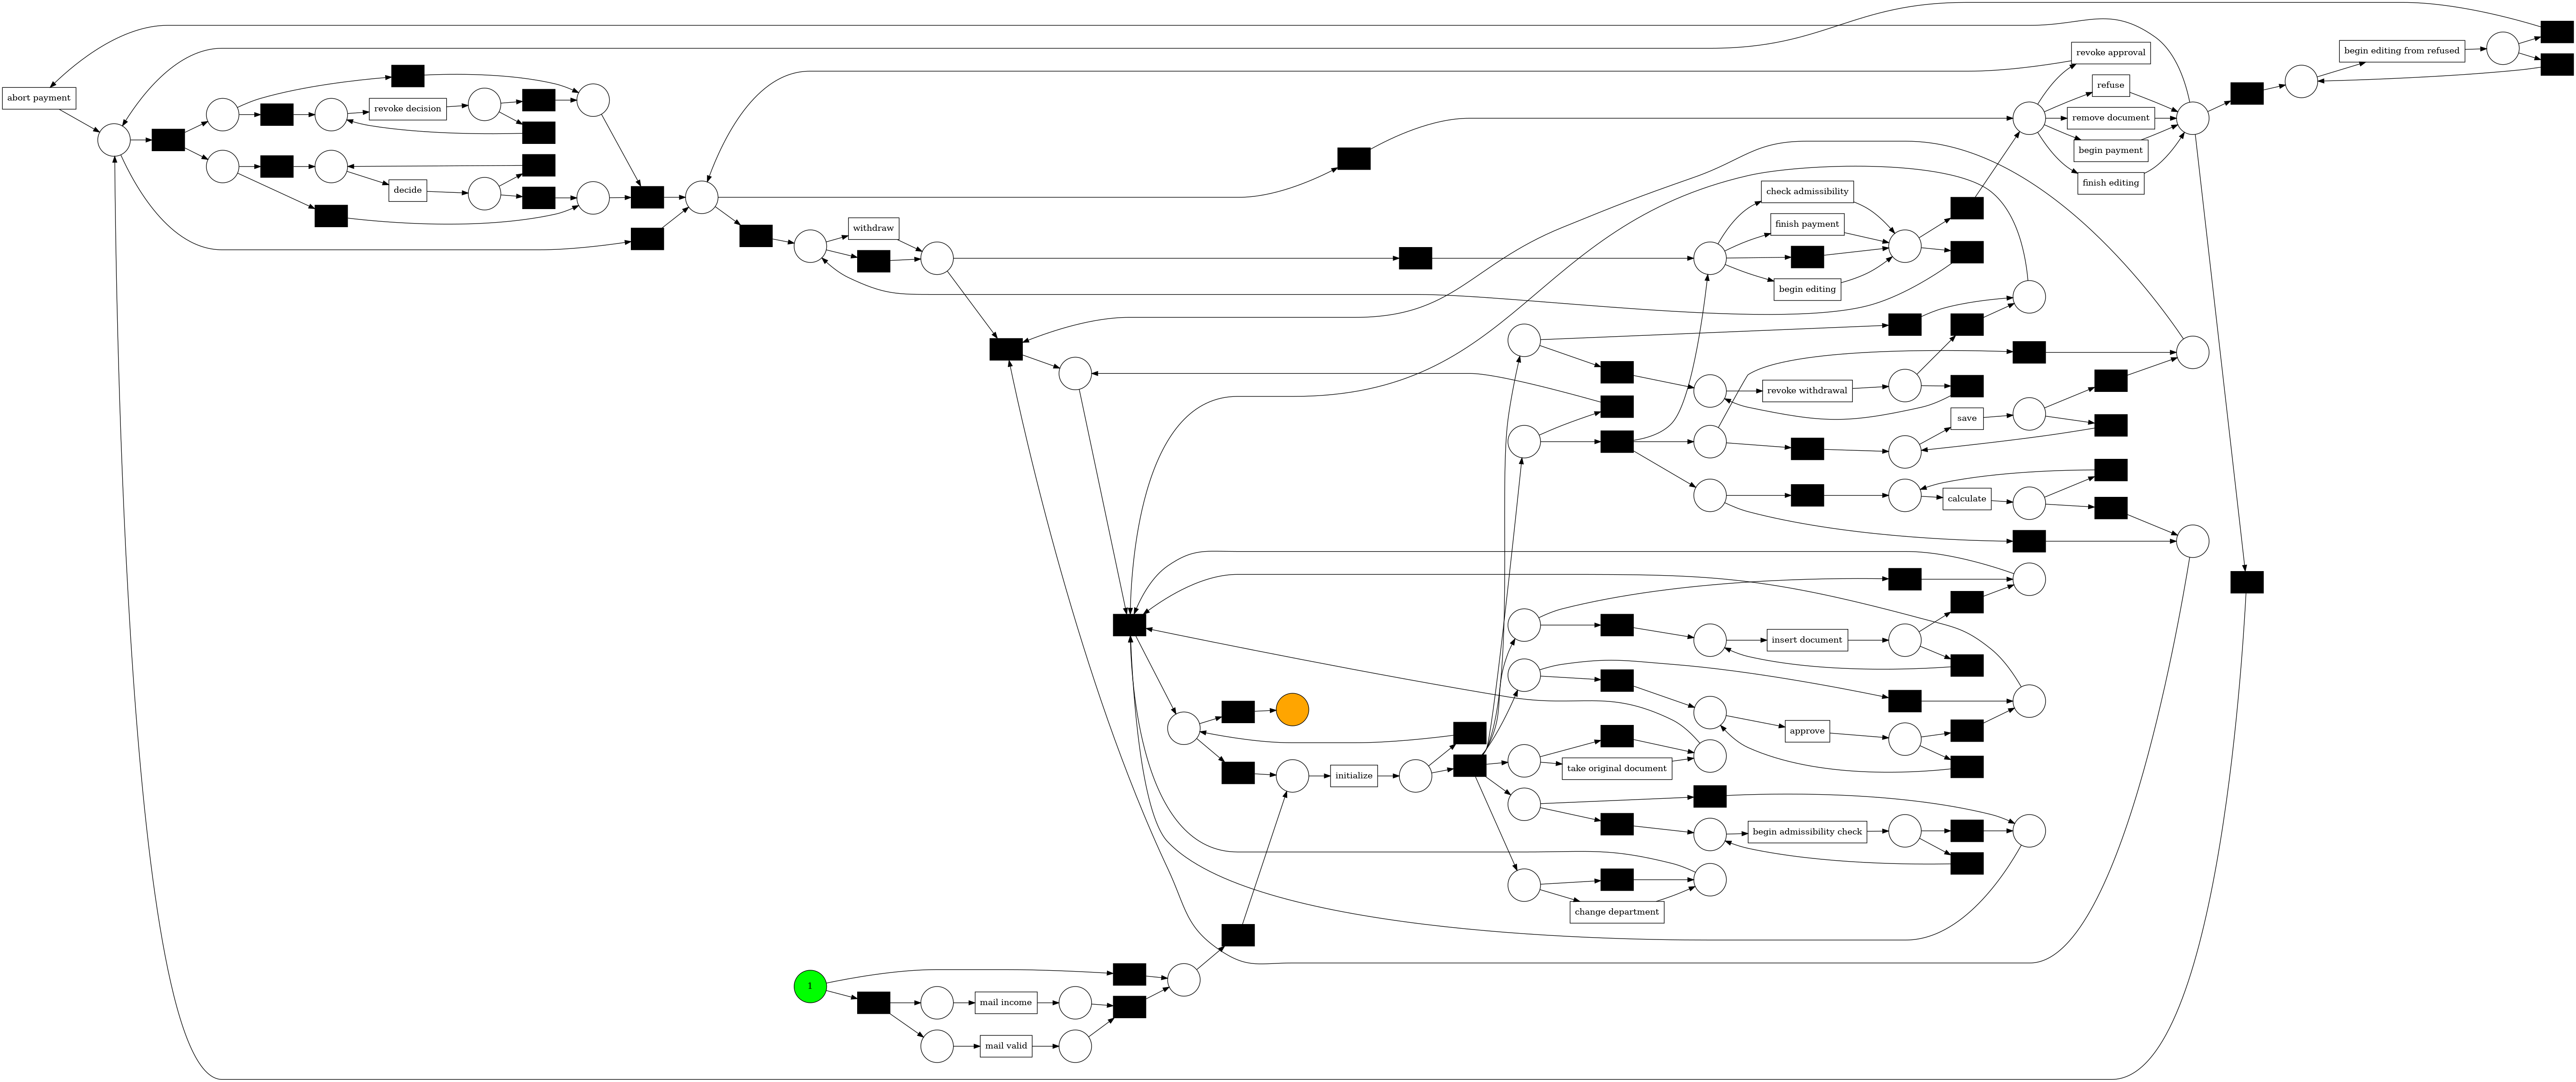

FileNotFoundError: [Errno 2] No such file or directory: './images/inductive_miner_Payment_Application.png'

In [35]:
"""Discover petri net based on """
#create petri net
net, initial_marking, final_marking = inductive_miner.apply(log, 
parameters={constants.PARAMETER_CONSTANT_CASEID_KEY: 'case:concept:name',
constants.PARAMETER_CONSTANT_ACTIVITY_KEY: "activity",
constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: "time:timestamp"})

# visualize petri net
gviz = pn_vis_factory.apply(net, initial_marking, final_marking)
pn_vis_factory.view(gviz)


In [36]:
visualizer.save(gviz, "inductive_miner_Payment_Application.png")

### XOR-split = begin payment 
from a business perspective, it is interesting to see whether we can predict what is going to happen after someone begins a payment

In [27]:
"""Calculate for each activity that has happened how many times it occured before our target split and 
additionally calculate the total duration up until the point of the split.

XOR-split = begin payment from a business perspective, 
it is interesting to see whether we can predict what is going to happen 
after someone begins a payment
"""
data = []

def parse_case(case):
    begin_payment = -1
    features = {}
    for i, e in enumerate(case):
        a = e["concept:name"]
        if a == "begin payment": # Next event is the target
            begin_payment = i
            break
        else:
            features[a] = features.get(a, 0) + 1
    features["label"] = case[begin_payment+1]["concept:name"]
    return features, case[begin_payment+1]["time:timestamp"]


for case_idx, c in enumerate(log):
    f = {}
    f["year"] = c[0]["time:timestamp"].year
    try:
        events, end_time = parse_case(c)
        f.update(events)
        f["duration"] = end_time - c[0]["time:timestamp"]
        f["duration"] = f["duration"].days
        data.append(f)
    except IndexError as e:
        print("There was no event after begin payment")
        
df = pd.DataFrame.from_dict(data)
df = df.replace(np.nan, 0)

In [28]:
"""Get some descriptive statistics to see if calculating this makes sense"""
print("All data")
print(df["label"].value_counts(normalize=True))
print("\n2015")
print(df.loc[df['year'] == 2015]["label"].value_counts(normalize=True))
print("\n2016")
print(df.loc[df['year'] == 2016]["label"].value_counts(normalize=True))
print("\n2017")
print(df.loc[df['year'] == 2017]["label"].value_counts(normalize=True))

All data
abort payment      0.564884
insert document    0.428907
finish payment     0.004337
mail income        0.001780
mail valid         0.000068
initialize         0.000023
Name: label, dtype: float64

2015
abort payment      0.994304
finish payment     0.005222
insert document    0.000271
mail income        0.000136
initialize         0.000068
Name: label, dtype: float64

2016
abort payment      0.692646
insert document    0.299313
finish payment     0.007698
mail income        0.000344
Name: label, dtype: float64

2017
insert document    0.994761
mail income        0.004894
mail valid         0.000207
abort payment      0.000069
finish payment     0.000069
Name: label, dtype: float64


In [29]:
"""Generate random train-test sets based on all cases starting in 2015
Ons model word getraind op cases waarvan de Events binnen die Case gebeuren TOT de split, 
op deze manier zorgen we dat we geen data uit de toekomst gebruiken.
Daarnaast hebben we als input voor het model alle cases in de dataset gepakt omdat trainen
op een bepaalt jaar een hele grote bias heeft op deze XOR-split, vervolgens hebben we
random 5% van de data gesampled om als validatie set te dienen.
"""

"""Remove 5% of the data to keep as a validation set"""
dataset = deepcopy(df)
X_val = dataset.sample(frac = 0.05, replace = False, random_state=200)
Y_val = X_val.pop("label").to_numpy()
dataset = dataset.drop(X_val.index)
X_val = X_val.drop(columns="year").to_numpy()

def train_test_split(dataframe, split_percentage=0.8, random_state=42):
    X_train = dataframe.sample(frac = split_percentage, replace = False, random_state=200).drop(columns="year")
    X_test = dataframe.drop(X_train.index).drop(columns="year")
    
    y_train = X_train.pop("label").to_numpy()
    y_test = X_test.pop("label").to_numpy()
    
    return X_train.to_numpy(), X_test.to_numpy(), y_train, y_test
    
X_train, X_test, y_train, y_test = train_test_split(dataset)

In [30]:
X_train.shape, X_test.shape, X_val.shape,

((33295, 20), (8324, 20), (2190, 20))

In [53]:
len(df)

43809

# Model training and prediction

In [31]:
"""Try multiple classfiers and check which predicts best"""
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

In [32]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    score = clf.score(X_val, Y_val)
    print(str(clf) + ": " + str(score))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform'): 0.8945205479452055
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'): 0.8863013698630137


In [34]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(Y_val, y_pred))
print("\n\nClassification report:")
print(classification_report(Y_val, y_pred))

Confusion matrix:
[[  0 747   0   0 518]
 [  0   0   0   0   0]
 [  0   8   0   0   6]
 [  0 554   0   0 351]
 [  0   4   0   0   2]]


Classification report:
                 precision    recall  f1-score   support

  abort payment       0.00      0.00      0.00      1265
  begin payment       0.00      0.00      0.00         0
 finish payment       0.00      0.00      0.00        14
insert document       0.00      0.00      0.00       905
    mail income       0.00      0.33      0.00         6

       accuracy                           0.00      2190
      macro avg       0.00      0.07      0.00      2190
   weighted avg       0.00      0.00      0.00      2190



/home/rowan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rowan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XOR-split = abort payment 
from a business perspective, it is interesting to see whether we can predict what is going to happen after someone begins a payment

In [14]:
"""Calculate for each activity that has happened how many times it occured before our target split and 
additionally calculate the total duration up until the point of the split.

XOR-split = abort payment from a business perspective, 
it is interesting to see whether we can predict what is going to happen 
after someone begins a payment
"""
data = []

def parse_case(case):
    begin_payment = -1
    features = {}
    for i, e in enumerate(case):
        a = e["concept:name"]
        if a == "abort payment": # Next event is the target
            begin_payment = i
            break
        else:
            features[a] = features.get(a, 0) + 1
    features["label"] = case[begin_payment+1]["concept:name"]
    return features, case[begin_payment+1]["time:timestamp"]


for case_idx, c in enumerate(log):
    f = {}
    f["year"] = c[0]["time:timestamp"].year
    try:
        events, end_time = parse_case(c)
        f.update(events)
        f["duration"] = end_time - c[0]["time:timestamp"]
        f["duration"] = f["duration"].days
        data.append(f)
    except IndexError as e:
        print("There was no event after begin payment")
        
df = pd.DataFrame.from_dict(data)
df = df.replace(np.nan, 0)

There was no event after begin payment
There was no event after begin payment
There was no event after begin payment
There was no event after begin payment
There was no event after begin payment


In [16]:
"""IDEM HIERBOVEN"""
dataset = deepcopy(df)
X_val = dataset.sample(frac = 0.05, replace = False, random_state=200)
Y_val = X_val.pop("label").to_numpy()
dataset = dataset.drop(X_val.index)
X_val = X_val.drop(columns="year").to_numpy()

def train_test_split(dataframe, split_percentage=0.8, random_state=42):
    X_train = dataframe.sample(frac = split_percentage, replace = False, random_state=200).drop(columns="year")
    X_test = dataframe.drop(X_train.index).drop(columns="year")
    
    y_train = X_train.pop("label").to_numpy()
    y_test = X_test.pop("label").to_numpy()
    
    return X_train.to_numpy(), X_test.to_numpy(), y_train, y_test
    
X_train, X_test, y_train, y_test = train_test_split(dataset)

In [25]:
"""Get some descriptive statistics to see if calculating this makes sense"""
print("All data")
print(df["label"].value_counts(normalize=True))
print("\n2015")
print(df.loc[df['year'] == 2015]["label"].value_counts(normalize=True))
print("\n2016")
print(df.loc[df['year'] == 2016]["label"].value_counts(normalize=True))
print("\n2017")
print(df.loc[df['year'] == 2017]["label"].value_counts(normalize=True))

All data
begin payment             0.606703
mail income               0.352000
mail valid                0.040088
remove document           0.000936
revoke decision           0.000137
insert document           0.000091
initialize                0.000023
take original document    0.000023
Name: label, dtype: float64

2015
begin payment             0.991659
mail income               0.004408
remove document           0.002780
mail valid                0.000678
revoke decision           0.000271
take original document    0.000068
insert document           0.000068
initialize                0.000068
Name: label, dtype: float64

2016
begin payment      0.692440
mail income        0.245979
mail valid         0.061375
insert document    0.000137
revoke decision    0.000069
Name: label, dtype: float64

2017
mail income        0.811957
begin payment      0.129086
mail valid         0.058819
revoke decision    0.000069
insert document    0.000069
Name: label, dtype: float64


In [18]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    score = clf.score(X_val, Y_val)
    print(str(clf) + ": " + str(score))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform'): 0.9502283105022831
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'): 0.9515981735159817


In [21]:
y_pred = clf.predict(X_val)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(Y_val, y_pred))
print("\n\nClassification report:")
print(classification_report(Y_val, y_pred))

Confusion matrix:
[[1311    0    0    0]
 [   0  773    0    0]
 [   0  104    0    0]
 [   2    0    0    0]]


Classification report:
                 precision    recall  f1-score   support

  begin payment       1.00      1.00      1.00      1311
    mail income       0.88      1.00      0.94       773
     mail valid       0.00      0.00      0.00       104
remove document       0.00      0.00      0.00         2

       accuracy                           0.95      2190
      macro avg       0.47      0.50      0.48      2190
   weighted avg       0.91      0.95      0.93      2190

